A lot of effort in solving any machine learning problem goes into preparing the data. Though the data that's shared with you is curated, you still need to write code to read and iterate through the dataset. The first section shows you how to create a pytorch dataset. It essentially implements two methods, __getitem__ and __len__.

please make sure the following packages are installed:


1. cv2: For reading images and transforms
2. pandas: For csv parsing
3. pytorch: A framework that makes training neural networks straight forward

### Mounting the data on collab
Add the zip file to a folder on gdrive. You'll be asked to authenticate to mount the folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# This is path that has training data on my google drive.
!ls /content/gdrive/MyDrive/cxr_plaksha_assignment_qure.zip

/content/gdrive/MyDrive/cxr_plaksha_assignment_qure.zip


In [ ]:
path="/content/gdrive/MyDrive/consolidation_train_gt (1).csv"

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv(path)

In [ ]:
df.head()

,filename,consolidation,consolidation-left,consolidation-right
0,19047,0,0,0
1,17924,0,0,0
2,11658,0,0,0
3,10733,0,0,0
4,15041,0,0,0


Replace the path with your own path and run this command the first time to extract the images. Note that this will unzip at the root path, if you want to extract at a different location, use -d

In [ ]:
# Verify that the zip file is extracted correctly.
!ls cxr_plaksha_assignment_qure | wc -l

20000


## Implementing a torch dataset and a dataloader(iterator on the dataset).

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [ ]:
# if you don't have pytorch installed in your collab environment, install it using !pip install torch
print(torch.__version__)

1.10.0+cu111


In [ ]:
# A helper function to read png images using cv2.
def read_image_from_path(path):
    try:

        return cv2.imread(path, 0)
    except Exception as e:
        print(f"error in fpath {path}")

A basic implementation of a torch dataset.

In [ ]:
class cls_dataset(Dataset):
    """A torch classification dataset class which returns each item in the form of dict consisting of keys idx, input, target.
    Transforms are applied on input images.
    """

    def __init__(self, images_path, ground_truth_path,mode):
        self.images_path = images_path
        self.gt_df = pd.read_csv(ground_truth_path, index_col="filename", usecols=["filename", "consolidation"])
        self.gt_dct=self.gt_df.to_dict()

        self.transforms = ToTensor()

        #self.transform=self.get_transforms(mode)
        #self.transforms = ToTensor()
        self.indices=[]
        if mode=='train':
          self.indices=[i for i in self.gt_df.index if i%5!=0]
        else:
           self.indices=[i for i in self.gt_df.index if i%5==0]
        print("mode=",mode,len(self.indices))

    def __len__(self):
        return len(self.gt_df.index)

    def __getitem__(self, index):

        idx = self.indices[index]

        input = self._get_input(idx)
        #print("input=",input)
        self.transforms=transforms.ToTensor()
        #self.transforms=transforms.Resize(size=(224,224))
        half = cv2.resize(input, (224, 224))
        input = self.transforms(half).float()


        targets = self._get_target(idx)

        return {"idx": idx, "input": input, "target": targets}

    def _get_input(self, idx):
        filepath = os.path.join(self.images_path, str(idx) + ".png")
        return read_image_from_path(filepath)

    def _get_target(self, idx):
        return self.gt_dct["consolidation"][idx]
    def get_transforms(self,mode='train'):
       if mode=='train':
         transform=transforms.Compose(
             [


              transforms.ToTensor(),
              transforms.Resize(size = (224,224)),

              transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),



             ]
         )
         return self.transform



### Once the dataset is implemented, you can use the torch.dataloader api to create smart iterators that you can use to automatically batch to process images parallely. In the example below, we are using a dataset of 4.

### **Data Loader**

In [ ]:
from PIL import Image
from numpy import asarray
import numpy as np

input= [[245 245 245 ... 245 245 245]
 [245 245 245 ... 245 245 245]
 [245 245 245 ... 231 245 245]
 ...
 [245 245 245 ...  71 169 231]
 [245 245 245 ... 218 245 245]
 [245 245 245 ... 245 245 245]]
input= [[226 225 221 ...   2   2   2]
 [ 72  70  67 ...   3   2   2]
 [  1   1   1 ...   3   3   3]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
input= [[83 85 87 ... 51 48 45]
 [92 89 86 ... 51 51 51]
 [83 84 85 ... 53 54 57]
 ...
 [ 4  4  4 ... 44 44 43]
 [ 4  4  4 ... 44 44 43]
 [ 4  4  4 ... 44 44 43]]
input= [[  0   0   0 ...   0   0   6]
 [  0   0   0 ...   0   0   5]
 [  0   0   0 ...   0   0   5]
 ...
 [246 246 246 ... 247 247 246]
 [246 246 246 ... 247 247 246]
 [246 246 246 ... 247 246 246]]
for index 19047 target is 0
for index 17924 target is 0
for index 11658 target is 0
for index 10733 target is 0


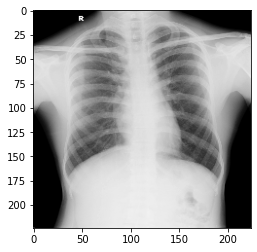

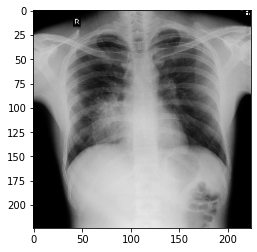

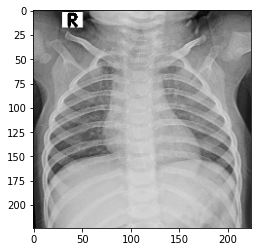

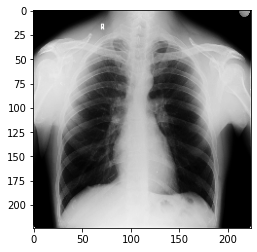

In [ ]:
images_path = "cxr_plaksha_assignment_qure"
ground_truth_path = "/content/gdrive/MyDrive/consolidation_train_gt.csv"
#images_path = torch.from_numpy(np.array(images_path, dtype='int32'))
train_ds = cls_dataset(images_path, ground_truth_path)
for batch in data.DataLoader(train_ds, batch_size=4):
    #print(batch)
    for i in range(0,4):
        print(f"for index {batch['idx'][i]} target is {batch['target'][i]}")
        image=torch.squeeze(batch['input'][i])
        #print(image.size())
        plt.figure(i)
        plt.imshow(image, cmap='gray')
    break

### **AlexNet**

In [ ]:
import torch.nn as nn
import math
from tqdm import tqdm as progress_bar

In [ ]:
class AlexNet(nn.Module):
  def __init__(self,num_classes:int=2,dropout:float=0.5)->None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels= 64, kernel_size= 11, stride=4, padding=2 ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding= 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.classifier=nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,num_classes),
        )
  def forward(self,x:torch.Tensor)->torch.Tensor:
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

In [ ]:
def conv3x3(in_planes,out_planes,stride=1):
  #3 x 3 convolution with padding
  return nn.Conv2d(in_planes,out_planes,kernel_size=3,stride=stride,padding=1,bias=False)

class BasicBlock(nn.Module):
  expansion=1
  def __init__(self,in_planes,out_planes,stride=1,downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1=conv3x3(in_planes,out_planes,stride)
    self.bn1=nn.BatchNorm2d(out_planes)
    self.relu=nn.ReLU(inplace=True)
    self.conv2=conv3x3(out_planes,out_planes,stride)
    self.bn2=nn.BatchNorm2d(out_planes)
    self.downsample=downsample
    self.stride=stride
  def forward(self,x:torch.Tensor)->torch.Tensor:
        output=self.conv1(x)
        output=self.bn1(output)
        output=self.relu(output)
        output=self.conv2(output)
        output=self.bn2(output)
        if self.downsample is not None:
          residual=self.downsample(x)
        output+=residual
        output=self.relu(output)
        return output
class BottleNeck(nn.Module):
  expansion=4
  def __init__(self,in_planes,out_planes,stride=1,downsample=None):
    super(BottleNeck, self).__init__()
    self.conv1=nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False)
    self.bn1=nn.BatchNorm2d(out_planes)
    self.conv2=nn.Conv2d(out_planes,out_planes,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn2=nn.BatchNorm2d(out_planes)
    self.conv3=nn.Conv2d(out_planes,out_planes*4,kernel_size=1,bias=False)
    self.bn3=nn.BatchNorm2d(out_planes*4)
    self.relu=nn.ReLU(inplace=True)
    self.downsample=downsample
    self.stride=stride
  def forward(self,x):
    residual=x
    out=self.conv1(x)
    out=self.bn1(out)
    out=self.relu(out)

    out=self.conv2(x)
    out=self.bn2(out)
    out=self.relu(out)
    out=self.conv2(x)
    out=self.bn2(out)
    if self.downsample is not None:
          residual=self.downsample(x)
    out+=residual
    out=self.relu(out)
    return out











In [ ]:
demo_image=train_ds[0]['input'].unsqueeze(0).float()
print(demo_image.size())

input= [[245 245 245 ... 245 245 245]
 [245 245 245 ... 245 245 245]
 [245 245 245 ... 231 245 245]
 ...
 [245 245 245 ...  71 169 231]
 [245 245 245 ... 218 245 245]
 [245 245 245 ... 245 245 245]]
torch.Size([1, 1, 224, 224])


In [ ]:
model=AlexNet()
prediction=model(demo_image)
print(prediction)

tensor([[-0.0081, -0.0117]], grad_fn=<AddmmBackward0>)


### **Splitting the dataset into training and validation dataset (80/20)**

In [ ]:
train_dataset=cls_dataset(images_path ,ground_truth_path,'train')
val_dataset=cls_dataset(images_path ,ground_truth_path,'val')
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset)}


mode= train 12775
mode= val 3225


In [ ]:
dataloader={'train':data.DataLoader(train_dataset,batch_size=4,shuffle=True),
            'val':data.DataLoader(val_dataset,batch_size=4,shuffle=False)}

### **Training the model**

In [ ]:
import time as time
import copy


In [ ]:
def train_model(model,criterion,optimizer,num_epochs):
  loss_dict={'train':[],'val':[]}
  accuracy_dict={'train':[],'val':[]}
  since=time.time()
  best_model_wts=copy.deepcopy(model.state_dict)
  best_acc=0
  for epoch in range(num_epochs):
    print('Epoch{}/{}'.format(epoch,num_epochs))
    print("*"*10)
    #Each epoch has a training and validation phase
    for phase in ['train','val']:
      if phase=='train':
        model.train()
      else:
        model.eval
      running_loss=0.0
      running_corrects=0
      #iterate over data
      for sample in progress_bar(dataloader[phase]) :
        inputs=sample['inputs'].to(torch.device)
        labels=sample['target'].to(torch.device)
        #zero the par gradients
        optimizer.zero_grad()
        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          outputs=model(inputs)
          _,preds=torch.max(outputs,1)
          loss=criterion(outputs,labels)
        #stats
        running_loss+=loss.item()*inputs.size(0)
        running_corrects+=torch.sum(preds==labels.data)

      epoch_loss=running_loss/dataset_sizes[phase]
      epoch_acc=running_corrects.double()/dataset_sizes[phase]
      loss_dict[phase].append(epoch_loss)
      accuracy_dict[phase].append(epoch_acc)
      print('{}Loss:{:4f}Acc:{4f}'.format(phase,epoch_loss,epoch_acc))
      if phase=='val' and epoch_acc>best_acc:
        best_acc=epoch_acc
        best_model_wts=copy.deepcopy(model.state_dict())
      print()
  time_elapsed=time.time()-since
  print('Best val acc: {4f}'.format(best_acc))
  #load best model wts
  model.load_sate_dict(best_model_wts)
  return model,loss_dict,accuracy_dict






In [ ]:
cost=torch.nn.CrossEntropyLoss()

model=AlexNet()
optimizer=torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=7)


In [ ]:
model=train_model(model,cost,exp_lr_scheduler,num_epochs=10)


Epoch0/10
**********
Train loss :   0.5834                       Train accuracy : 0.7332

Val loss :   0.582                           Val accuracy : 0.7318
_____________________________________________________________________________________________________
Epoch1/10
**********
Train loss :   0.5819                       Train accuracy : 0.7334

Val loss :   0.5792                           Val accuracy : 0.7324
_____________________________________________________________________________________________________
Epoch2/10
**********
Train loss :   0.562                       Train accuracy : 0.7349

Val loss :   0.5605                           Val accuracy : 0.7339
_____________________________________________________________________________________________________
Epoch3/10
**********
Train loss :   0.559                       Train accuracy : 0.7356

Val loss :   0.5543                           Val accuracy : 0.7345
_________________________________________________________________